<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Import-of-Python-modules" data-toc-modified-id="Import-of-Python-modules-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Import of Python modules</a></span></li><li><span><a href="#Class-for-generation-of-blade-profile" data-toc-modified-id="Class-for-generation-of-blade-profile-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Class for generation of blade profile</a></span></li></ul></div>

## Import of Python modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
from scipy import interpolate
from mpl_toolkits.mplot3d import Axes3D

In [2]:
pathToFreeCAD = "F:/Progs/FreeCAD/FreeCAD-0.18.4.980bf90-WIN-x64-portable/conda-0.18.4/bin"
sys.path.append(pathToFreeCAD)

import FreeCAD, Part

## Class for generation of blade profile

In [3]:
class BladeProfile():
    def __init__(self, L, Beta_array, R_array, T_array, CoefLe=2, CoefTe=2, N=5000, N_LeTe = 30):
        self.L = L
        self.Beta_array = Beta_array
        self.R_array = R_array
        self.T_array = T_array
        self.CoefLe = CoefLe
        self.CoefTe = CoefTe
        self.N = N
        self.N_LeTe = N_LeTe
    
    def Generate2Dprofile(self):
        '''Generation 2D profile of the blade, function returns XY coordinates of the profile'''
        L = self.L
        Beta_array = self.Beta_array
        R_array = self.R_array
        T_array = self.T_array
        CoefLe = self.CoefLe
        CoefTe = self.CoefTe
        N = self.N
        N_LeTe = self.N_LeTe
        
        FirstP = CoefLe*T_array[0]*np.cos(Beta_array[0]/180*np.pi)/2.0
        LastP = CoefTe*T_array[-1]*np.cos(Beta_array[-1]/180*np.pi)/2.0
        dx_i = np.linspace(0+FirstP, L-LastP, N)    # Split of the horizontal length of the blade
        dx = dx_i[1:]-dx_i[:-1]
        dx_beta_func = np.linspace(0, L, Beta_array.shape[0])   # Split length of blade for generation function beta = f(x)
        beta_func = interpolate.interp1d(dx_beta_func, Beta_array, kind='quadratic') # function beta f(x)
        Beta_i = beta_func(dx_i[1:])       # Calculation of the beta values for dx coordinates    
        dy = dx*np.tan(Beta_i/180.0*np.pi)    # Calculation dy coordinates of the blade
        dy_i = np.array([dy[:i+1].sum() for i in range(dy.shape[0])])+np.sqrt((CoefLe*T_array[0])**2/4-FirstP**2)

        # Thickness of the streamline
        dx_thick_func = np.linspace(0, L, T_array.shape[0])
        thick_func = interpolate.interp1d(dx_thick_func, T_array, kind='quadratic')
        T_i = thick_func(dx_i[1:])

        dl = np.sqrt(dx**2+dy**2)
        Alpha_i = np.arctan(T_i/dl/2)
        dm = np.sqrt(dl**2+(T_i/2.0)**2)
        T_y1 = dm*np.sin(Alpha_i+(Beta_i/180*np.pi))
        T_x1 = dm*np.cos(Alpha_i+(Beta_i/180*np.pi))
        T_y2 = dm*np.sin((Beta_i/180*np.pi)-Alpha_i)
        T_x2 = dm*np.cos((Beta_i/180*np.pi)-Alpha_i)

        T_y1i = T_y1+dy_i
        T_x1i = T_x1+dx_i[1:]
        T_y2i = T_y2+dy_i
        T_x2i = T_x2+dx_i[1:]
        
        if CoefLe == 1:
            # Creation of the coordinates of Leading Edge of the Airfoil
            ArcLe = Part.Arc(FreeCAD.Vector(T_x2i[0], T_y2i[0], 0), FreeCAD.Vector(0, 0, 0), FreeCAD.Vector(T_x1i[0], T_y1i[0], 0))
            Le_list = ArcLe.discretize(Number=32)
            Le_x = np.array([Le_list[i].x for i in range(len(Le_list))])
            Le_y = np.array([Le_list[i].y for i in range(len(Le_list))])
        else:   
            # Ellipse type of the Leading Edge
            MajorR = App.Vector(0, 0, 0)
            MinorR = App.Vector(T_x1i[0], T_y1i[0], 0)
            Center = App.Vector(dx_i[0], dy_i[0], 0)
            ArcEllLe = Part.ArcOfEllipse(Part.Ellipse(MajorR, MinorR, Center),-1.5, 1.5)
            Le_list = ArcEllLe.discretize(Number=30)
            Le_list.append(MinorR)
            Le_list.insert(0, App.Vector(T_x2i[0], T_y2i[0], 0))
            Le_x = np.array([Le_list[i].x for i in range(len(Le_list))])
            Le_y = np.array([Le_list[i].y for i in range(len(Le_list))])    
        
        if CoefTe == 1:
            #Creation of the coordinates Trailing Edge of the Airfoil
            LastP_y = dy_i[-1]+np.sqrt((CoefTe*T_array[-1])**2/4-LastP**2)
            ArcTe = Part.Arc(FreeCAD.Vector(T_x1i[-1], T_y1i[-1], 0), FreeCAD.Vector(L, LastP_y, 0), FreeCAD.Vector(T_x2i[-1], T_y2i[-1], 0))
            Te_list = ArcTe.discretize(Number=32)
            Te_x = np.array([Te_list[i].x for i in range(len(Te_list))])
            Te_y = np.array([Te_list[i].y for i in range(len(Te_list))])
        else:
            # Ellipse type of the Trailling Edge
            LastP_y = dy_i[-1]+np.sqrt((CoefTe*T_array[-1])**2/4-LastP**2)
            MajorR_Te = App.Vector(L, LastP_y, 0)
            MinorR_Te = App.Vector(T_x1i[-1], T_y1i[-1], 0)
            Center_Te = App.Vector(dx_i[-1], dy_i[-1], 0)
            ArcEllTe = Part.ArcOfEllipse(Part.Ellipse(MajorR_Te, MinorR_Te, Center_Te),-1.5, 1.5)
            Te_list = ArcEllTe.discretize(Number=30)
            Te_list.append(MinorR_Te)
            Te_list.insert(0, App.Vector(T_x2i[-1], T_y2i[-1], 0))
            Te_x = np.flip(np.array([Te_list[i].x for i in range(len(Te_list))]))
            Te_y = np.flip(np.array([Te_list[i].y for i in range(len(Te_list))]))      
        
        # Compound of the all XY coordinates
        X1 = np.array([Le_x, T_x1i, Te_x, np.flip(T_x2i)])
        Y1 = np.array([Le_y, T_y1i, Te_y, np.flip(T_y2i)])
        
        # Creation of the list with FreeCAD Vectors of the streamline
        ListStreamline = []
        for i in range(dy_i.shape[0]):
            v_i = FreeCAD.Vector(dx_i[i], dy_i[i], 0)
            ListStreamline.append(v_i)
        
        SplineStreamline = Part.BSplineCurve()
        SplineStreamline.interpolate(ListStreamline)
        SplineStreamline = SplineStreamline.toShape()
        CenterMass = SplineStreamline.CenterOfMass
        
        X = X1-CenterMass.x
        Y = Y1-CenterMass.y
        
        return X, Y
    
    def View2DAirfoil(self, X_arrays, Y_arrays):
        X1 = np.append(X_arrays[0], X_arrays[1])
        Y1 = np.append(Y_arrays[0], Y_arrays[1])
        X2 = np.append(X_arrays[2], X_arrays[3])
        Y2 = np.append(Y_arrays[2], Y_arrays[3])
        X = np.append(X1, X2)
        Y = np.append(Y1, Y2)
        plt.xlabel('X, [mm]')
        plt.ylabel('Y, [mm]')
        plt.plot(X, Y)
        plt.grid()
        plt.axis('equal')
        plt.show()
    
    def Generate3Dprofile(self, X_arrays, Y_arrays):
        '''Generation of the 3D coordinates of the profile with using Conformal Method'''
        L = self.L
        Beta_array = self.Beta_array
        R_array = self.R_array
        T_array = self.T_array
        CoefLe = self.CoefLe
        CoefTe = self.CoefTe
        N = self.N
        N_LeTe = self.N_LeTe
        
        dx_merid_func = np.linspace(X_arrays[0].min()-T_array[0], X_arrays[2].max()+T_array[-1], R_array.shape[0])  
        merid_func = interpolate.interp1d(dx_merid_func, R_array, kind='quadratic')
        R_i1 = merid_func(X_arrays[1])
        x_ps = R_i1*np.cos(X_arrays[1]/R_i1)
        y_ps = R_i1*np.sin(X_arrays[1]/R_i1)
        z_ps = Y_arrays[1]

        R_i2 = merid_func(X_arrays[3])
        x_ss = R_i2*np.cos(X_arrays[3]/R_i2)
        y_ss = R_i2*np.sin(X_arrays[3]/R_i2)
        z_ss = Y_arrays[3]

        R_le = merid_func(X_arrays[0])
        x_le = R_le*np.cos(X_arrays[0]/R_le)
        y_le = R_le*np.sin(X_arrays[0]/R_le)
        z_le = Y_arrays[0]

        R_te = merid_func(X_arrays[2])
        x_te = R_te*np.cos(X_arrays[2]/R_te)
        y_te = R_te*np.sin(X_arrays[2]/R_te)
        z_te = Y_arrays[2]

        x1 = np.append(x_le, x_ps)
        y1 = np.append(y_le, y_ps)
        z1 = np.append(z_le, z_ps)
        x2 = np.append(x_te, x_ss)
        y2 = np.append(y_te, y_ss)
        z2 = np.append(z_te, z_ss)
        x = np.append(x1, x2)
        y = np.append(y1, y2)
        z = np.append(z1, z2)
        
        return x, y, z

    def View3DAirfoil(self, X, Y, Z):
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.plot(X, Y, Z)
        ax.set_aspect('equal')
        
        max_range = np.array([X.max()-X.min(), Y.max()-Y.min(), Z.max()-Z.min()]).max()
        Xb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][0].flatten() + 0.5*(X.max()+X.min())
        Yb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][1].flatten() + 0.5*(Y.max()+Y.min())
        Zb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][2].flatten() + 0.5*(Z.max()+Z.min())
        # Comment or uncomment following both lines to test the fake bounding box:
        for xb, yb, zb in zip(Xb, Yb, Zb):
           ax.plot([xb], [yb], [zb], 'w')   

In [4]:
Beta_arr1 = np.array([15, 20, 50])
R_arr1 = np.array([60, 60, 60])
T_arr1 = np.array([2, 4, 3, 2])

Beta_arr2 = np.array([25, 30, 35])
R_arr2 = np.array([20, 30, 40])
T_arr2 = np.array([3, 5, 4, 3])

Profile1 = BladeProfile(120, Beta_array=Beta_arr1, R_array=R_arr1, T_array=T_arr1, CoefLe=1, CoefTe=1)
Profile2 = BladeProfile(50, Beta_array=Beta_arr2, R_array=R_arr2, T_array=T_arr2, CoefLe=1, CoefTe=1)

In [5]:
X1, Y1 = Profile1.Generate2Dprofile()
x1, y1, z1 = Profile1.Generate3Dprofile(X1, Y1)

#X2, Y2 = Profile2.Generate2Dprofile()
#x2, y2, z2 = Profile2.Generate3Dprofile(X2, Y2)

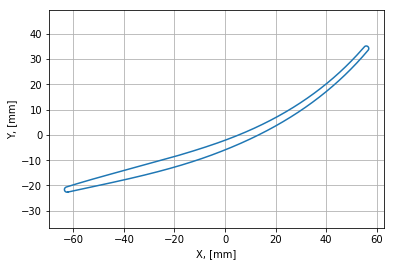

In [6]:
Profile1.View2DAirfoil(X1, Y1)

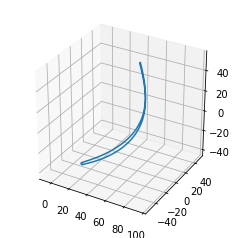

In [7]:
Profile2.View3DAirfoil(x1, y1, z1)